# Combining PennyLane with Amazon Braket

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

# Setup

In [2]:
import pennylane as qml
from pennylane import numpy as np

In [3]:
wires = 2  # Number of qubits

dev = qml.device("braket.local.qubit", wires=wires)

Defining a circuit


We will choose a simple two-qubit circuit with two controllable rotations and a CNOT gate.

In [4]:
@qml.qnode(dev)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(1))

# Evaluating the circuit and accessing its gradient

In [5]:
params = np.array([0.2, 0.3], requires_grad=True)

In [6]:
print("Expectation value of circuit:", circuit(params))

Expectation value of circuit: 0.9362933635841993


In [7]:
print("Drawing of circuit:\n")
print(qml.draw(circuit)(params))

Drawing of circuit:

0: ──RX(0.20)─╭C─┤     
1: ──RY(0.30)─╰X─┤  <Z>


A crucial element of machine learning and optimization is accessing the gradient of a model with respect to its parameters. This functionality is built into PennyLane:

Here, dcircuit is a callable function that evaluates the gradient of the circuit, i.e., its partial derivatives with respect to the controllable parameters.

In [8]:
dcircuit = qml.grad(circuit)

In [9]:
dcircuit(params)

array([-0.18979606, -0.28962948])

# Training the circuit




Suppose we now want to minimize the output of the circuit by updating its parameters. This can be done using gradient-based optimization.

First, an optimizer is fixed:

In [11]:
opt = qml.GradientDescentOptimizer(stepsize=0.2)

The next step is to run the optimizer for a chosen number of iterations:

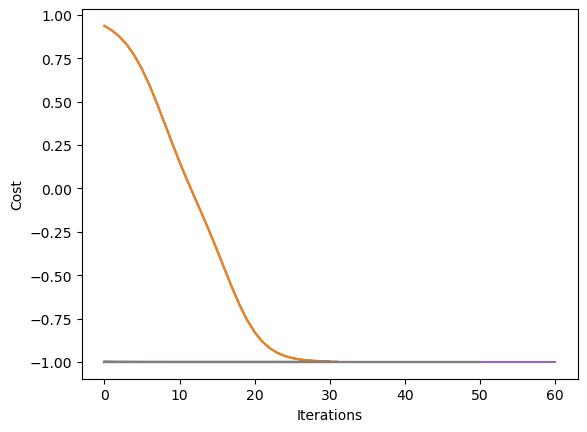

Minimized circuit output: -1.0
Optimized parameters: [9.33464278e-17 3.14159265e+00]


In [19]:
iterations = 50

costs = []

for i in range(iterations):
    params, cost = opt.step_and_cost(circuit, params)
    costs.append(cost)

# Visualize results
import matplotlib.pyplot as plt    
costs.append(circuit(params))
plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()


print("Minimized circuit output:", circuit(params))
print("Optimized parameters:", params)

# Running circuits on Braket's on-demand simulator, SV1

In [20]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

In [21]:
dev = qml.device('braket.aws.qubit', device_arn=device_arn, wires=2)

Let's execute our circuit on SV1, as well as calculating the gradient:

In [22]:
@qml.qnode(dev)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(1))


dcircuit = qml.grad(circuit)

print("Result of circuit run on SV1:", circuit(params))
print("Result of gradient calculation on SV1:", dcircuit(params))

Result of circuit run on SV1: -1.0
Result of gradient calculation on SV1: [ 6.16297582e-32 -1.02695630e-15]


In [23]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 0, 'tasks': {'COMPLETED': 6}, 'execution_duration': datetime.timedelta(microseconds=155000), 'billed_execution_duration': datetime.timedelta(seconds=18)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.022 USD
